<a href="https://colab.research.google.com/github/katarinagresova/M7DataSP_2020/blob/dokoncenie/assignment_10/blue_book_for_bulldozers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is working with data from kaggle [Blue Book for Bulldozers](https://www.kaggle.com/c/bluebook-for-bulldozers) competition. Goal is to predict the auction sale price for a piece of heavy equipment to create a "blue book" for bulldozers. To use the final model, feel free to download it [here](https://drive.google.com/file/d/1SvEqWfhQ3SmdyYJPC35BLrMHtmK-3i4J/view?usp=sharing). (You may need to open the link using your Muni acc)

# Setup

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score, precision_score, recall_score, mean_squared_error, r2_score


In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

# Data load

In [3]:
df = pd.read_csv("/notebooky/Data/TrainAndValid.csv", parse_dates=['saledate'], low_memory = False)

In [5]:
df = pd.read_csv("F:\Data\TrainAndValid.csv", parse_dates=['saledate'], low_memory = False) 

## From Google Drive

In [1]:
df = pd.read_csv('/content/drive/MyDrive/M7DataSP/blue_book_for_bulldozers/TrainAndValid.csv', parse_dates=['saledate'], low_memory = False) 

In [4]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

# Data preprocessing

In [6]:
# df['saledate'] = pd.to_datetime(df.saledate).values.astype(np.int64)//10 ** 9 # convert date to timestamp to obtain a new explanatory varialble , if parse_dates in the begging was not used, but we d be good only with the year of sale as integer value
df.saledate = df.saledate.dt.year

In [7]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df.SalePrice= np.log(df.SalePrice) #  we will work with log of saleprice as it was stated in the rules of competition

In [9]:
for_pred = df.drop(columns = 'SalePrice')
important = for_pred.isnull().sum()/len(df)*100 < 90
# this caviat is needed in the part used for prediction

In [10]:
df = df[df.columns[(df.isnull().sum()/len(df)*100 < 90)]] # delete columns of which more than 90% are missing values
object_cols = df.select_dtypes("object").columns  # select object columns
df[object_cols] = df[object_cols].astype(str) # transform all object columns to strings (some contained both str and int, and it did not good with further preprocessing)


In [11]:
df[object_cols] = df[object_cols].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 46 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 412698 non-null  category
 9   saledate                  412698 non-null  int64   
 10  fiModelDesc               412698 non-null  category
 11  fiBaseModel               412698 non-null  category
 12  fiSecondaryDesc           412698 non-null  category
 13  fiModelSeries             412

In [12]:
unimportant_columns = ['SalesID', 'MachineID', 'auctioneerID', 'ModelID', 'fiModelDesc'] # first look at the data assumtions
print('Unique values:')
for col in unimportant_columns:
    print(col,': ',len(df[col].unique())) # the first two are unique ID which are not explanatory variable. ModelID and fiModelDesc are almost same things(see data disctionary on kaggle), so we use only fiModelDesc.... auctioneerID is an explanatory variable

Unique values:
SalesID :  412698
MachineID :  348808
auctioneerID :  31
ModelID :  5281
fiModelDesc :  5059


<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

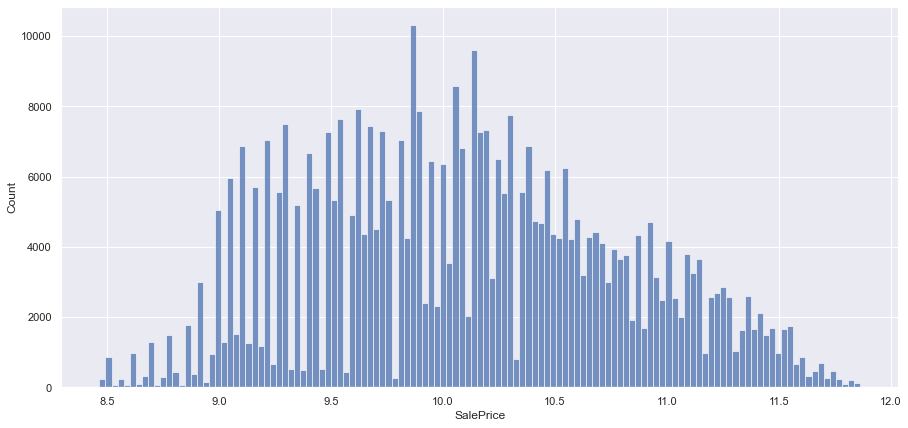

In [13]:
bulldozers_X, bulldozers_y = df.drop(columns = ['SalePrice','SalesID', 'MachineID', 'ModelID']), df.SalePrice 
sns.set() 
plt.figure(figsize=(15,7))
sns.histplot(bulldozers_y)

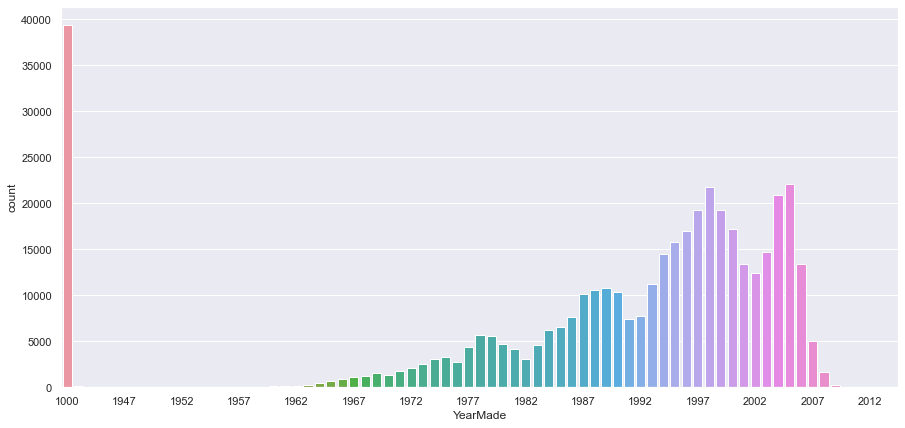

In [14]:
plt.figure(figsize=(15,7))
plot = sns.countplot(data=bulldozers_X, x="YearMade", )
new_ticks = [i.get_text() for i in plot.get_xticklabels()]
plt.xticks(range(0, len(new_ticks), 5), new_ticks[::5])
None

<AxesSubplot:xlabel='saledate', ylabel='count'>

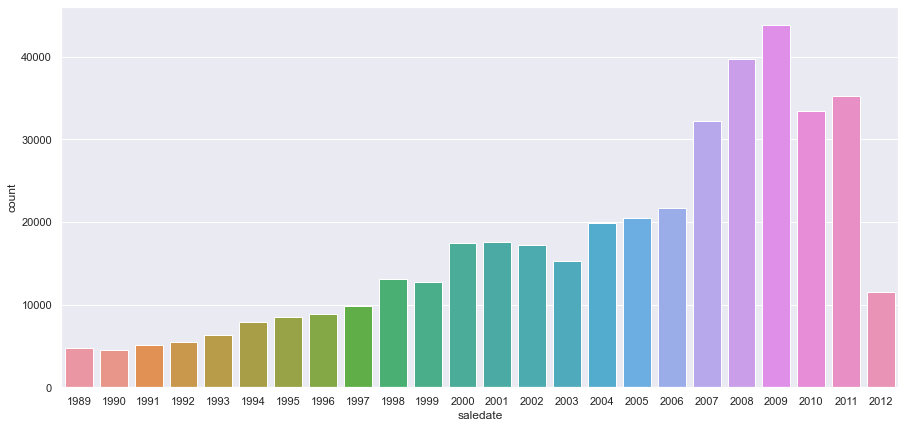

In [15]:
plt.figure(figsize=(15,7))
sns.countplot(data=bulldozers_X, x="saledate", ) 

In [16]:
df.UsageBand.value_counts() # usage of the buldozzers are in 3 categories plus nan

nan       339028
Medium     35832
Low        25311
High       12527
Name: UsageBand, dtype: int64

In [17]:
df.UsageBand.cat.set_categories(['nan', 'Low', 'Medium', 'High'], ordered=True, inplace=True) # we set the categories to be ordered by the amount of usage
df.UsageBand

0            Low
1            Low
2           High
3           High
4         Medium
           ...  
412693       nan
412694       nan
412695       nan
412696       nan
412697       nan
Name: UsageBand, Length: 412698, dtype: category
Categories (4, object): ['nan' < 'Low' < 'Medium' < 'High']

In [18]:
X_train, X_val, y_train, y_val= train_test_split(
    bulldozers_X, bulldozers_y, test_size=0.2, random_state=18
) # validation and train set with reproducible random_state set

In [19]:
bulldozers_X.corr() # not serious correlation between numerical variables

,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saledate
datasource,1.000000,-0.019021,0.070933,0.009747,0.354394
auctioneerID,-0.019021,1.000000,-0.019037,0.030911,-0.060987
YearMade,0.070933,-0.019037,1.000000,-0.011598,-0.042783
MachineHoursCurrentMeter,0.009747,0.030911,-0.011598,1.000000,0.028243
saledate,0.354394,-0.060987,-0.042783,0.028243,1.000000


# Training the model

In [20]:
num_features = X_train.select_dtypes("number").columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # for the missing numerical value we input the mean of the column
    ('scaler', StandardScaler())])

cat_features = X_train.select_dtypes("category").columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values='nan', strategy='constant', fill_value = 'missing')), # for missing value we add a new category 'missing'
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])


preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
])


                                                          

In [21]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def print_score(m, X_train = X_train, y_train = y_train, tstx = X_val, tsty = y_val):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(tstx), tsty),
                m.score(X_train, y_train), m.score(tstx, tsty)]
    tart = ['rmse train', 'rmse test', 'R2 train', 'R2 test']
    for v in range(len(res)):
        print(tart[v], ":", res[v], end = "\n")
        

## Decision tree regressor


In [56]:
reg_tree =  Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', DecisionTreeRegressor(
                                criterion = 'mse',
                                random_state = 18,
                                splitter = 'best',
                                min_samples_split = 8,
                                min_samples_leaf = 3,
                                     ))])

In [57]:
reg_tree.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['datasource', 'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter',
       'saledate'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 missing_values='nan',
                                                                      

In [58]:
print_score(reg_tree)


rmse train : 0.14841029267411754
rmse test : 0.2581066320892598
R2 train : 0.954392823864948
R2 test : 0.8621761362985874


## Random forest regressor


In [59]:
rfr =  Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', RandomForestRegressor(
                                n_estimators = 70,
                                criterion = 'mse',
                                random_state = 18,
                                bootstrap = True,
                                 min_samples_split = 10,
                                min_samples_leaf = 5,
                                max_features = 0.5,
                                max_samples = 0.5,
                                n_jobs = -2,   # parallel processes  
                                warm_start = True   
                                ))])

In [60]:
%%time
rfr.fit(X_train, y_train)
#with warm start = True

Wall time: 1h 41min 9s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['datasource', 'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter',
       'saledate'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 missing_values='nan',
                                                                      

In [61]:
print_score(rfr)
# with warm start = True

rmse train : 0.1964609656350591
rmse test : 0.22340001639155205
R2 train : 0.9200795927220615
R2 test : 0.8967494214163518


## Finding the best hypperparameters


### Random forest


In [30]:
rf_grid = {
    "min_samples_split": [10, 15, 20],
    "min_samples_leaf": [5, 10, 20],
    #"ccp_alpha": [0.0, 0.001, 0.01],
    "max_samples": [0.3,0.5],
    "max_features": [0.3, 0.5],
    "n_estimators": [70],
}
rf_model = RandomForestRegressor(
    criterion = 'mse',
    warm_start = True)

gs_rf = Pipeline(steps=[('preprocessor', preprocessor),
                        ('gs', GridSearchCV(rf_model, rf_grid, n_jobs = -1, cv = 3, refit = True, verbose = 5))])

In [31]:
%%time
gs_rf.fit(bulldozers_X , bulldozers_y)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Wall time: 8h 33min 11s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['datasource', 'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter',
       'saledate'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 missing_values='nan',
                                                                      

In [35]:
gs_rf['gs'].best_params_

{'max_features': 0.5,
 'max_samples': 0.5,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 70}

In [36]:
gs_rf['gs'].best_score_ # mean cross validated score

0.8173006974191548

In [63]:
estimator = gs_rf['gs'].best_estimator_

# Evaluating on test set


## Data load

### From local machine

In [38]:
X_test = pd.read_csv("/notebooky/Data/Test.csv", parse_dates=['saledate'], low_memory = False) 

In [39]:
y_test = pd.read_csv("/notebooky/Data/Random_forest_benchmark_test.csv",  low_memory = False)


### From Google Drive

In [ ]:
X_test = pd.read_csv('/content/drive/MyDrive/M7DataSP/blue_book_for_bulldozers/Test.csv', parse_dates=['saledate'], low_memory = False) 

In [ ]:
y_test = pd.read_csv('/content/drive/MyDrive/M7DataSP/blue_book_for_bulldozers/Random_forest_benchmark_test.csv',  low_memory = False)

## Data preprocessing

In [40]:
set(df.columns) - set(X_test.columns) # the test dataset is without the Saleprice. However, this column we have in Random_forest_benchmark_test.csv


{'SalePrice'}

In [41]:
# Processing of price column
y_test = y_test.SalePrice
y_test= np.log(y_test) #  we will work with log of saleprice as it was stated in the rules of competition


In [42]:
y_test.shape, X_test.shape


((12457,), (12457, 52))

In [43]:
X_test.saledate = X_test.saledate.dt.year
X_test = X_test[X_test.columns[important]] # delete columns of which more than 90% are missing values from the train set
X_test[object_cols] = X_test[object_cols].astype(str) # same preprocessing as on train set
X_test[object_cols] = X_test[object_cols].astype('category')
X_test.UsageBand.cat.set_categories(['nan', 'Low', 'Medium', 'High'], ordered=True, inplace=True)



In [44]:
X_test = X_test.drop(columns = ['SalesID', 'MachineID', 'ModelID'])
X_train.shape, X_test.shape

((330158, 42), (12457, 42))

In [55]:
print_score(gs_rf, bulldozers_X, bulldozers_y, X_test, y_test) # skore na testovacich datach v porovnani s benchmarkokm na urovni 0.96 R2 skore

rmse train : 0.1933177345457528
rmse test : 0.1343159295823248
R2 train : 0.9226306840657036
R2 test : 0.9621487367655378


In [64]:
import pickle

In [65]:
filename = 'final_model.sav'

In [66]:
pickle.dump(gs_rf, open(filename, 'wb'))

In [67]:
saved_model = pickle.load(open(filename, 'rb'))